In [58]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from random import randint
from PIL import Image
from math import sqrt
from math import sin
from math import cos
from math import pi
from math import floor
from math import ceil
import operator #for sorting array of tuples
from time import time

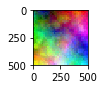

In [59]:
img = cv2.imread('som-ic2.jpg')
#import SOM-image and convert to rgb
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(1,1))
plt.imshow(img_rgb)

dist = int(500/32)#image width is 500
col_arr = []
#create 2-dimensional array of colors from SOM-image
for x in range(0, 32):
    yArr = []
    for y in range(0, 32):
        yArr.append(img_rgb[x*dist][y*dist])
    col_arr.append(yArr)

In [62]:
#when node is initialized with a number of leaves
#it recursively generates a (random) binary tree 
class Node:
    #leftChild: None or new Node
    #rightChild: None or new Node
    #ar – aspect ratio: calculated from leftChild.ar and rightChild.ar
    #sliceDirection: "V"(0) or "H"(1) or None, when it's a leaf
    def __init__(self, numOfLeaves, aspectRatio, parent, width, height, position, rects, image):        
        self.leftChild = None
        self.rightChild = None
        self.sliceDirection = None
        self.aspectRatio = aspectRatio
        self.image = image
        self.parent = parent
        self.width = width
        self.height = height
        self.position = position
        
        if(numOfLeaves == 1 and self.image == None): #this node is a leaf
            #select image/rect from rects, that best fits the aspectRatio
            self.image = findBestImg(aspectRatio, rects)
            
        if(numOfLeaves == 2): #this node is inner node with two leaves
            image1, image2 = findImagePair(aspectRatio, rects)
            if(width/height < aspectRatio):
                self.sliceDirection = 0
            else:
                self.sliceDirection = 1
            if(self.sliceDirection == 0): #vertical slice
                childWidth = height * (aspectRatio/2)
                childHeight = height
                leftPos = position
                rightPos = ((position[0] + width - childWidth), position[1])
                self.leftChild = Node(floor(numOfLeaves/2), aspectRatio/2, self, childWidth, childHeight, leftPos, rects, image1)
                self.rightChild = Node(ceil(numOfLeaves/2), aspectRatio/2, self, childWidth, childHeight, rightPos, rects, image2)
            else: #horizontal slice
                childWidth = width
                childHeight = width / (aspectRatio*2)
                leftPos = position
                rightPos = (position[0], (position[1] + height - childHeight))
                self.leftChild = Node(floor(numOfLeaves/2), aspectRatio*2, self, childWidth, childHeight, leftPos, rects, image1)
                self.rightChild = Node(ceil(numOfLeaves/2), aspectRatio*2, self, childWidth, childHeight, rightPos, rects, image2)
         
        if(numOfLeaves >= 2): #this node is an inner node with two children
            self.sliceDirection = randint(0,1) #random int 0 for "V", or 1 for "H"
            if(self.sliceDirection == 0): #vertical slice
                childWidth = height * (aspectRatio/2)
                childHeight = height
                leftPos = position
                rightPos = ((position[0] + width - childWidth), position[1])
                self.leftChild = Node(floor(numOfLeaves/2), aspectRatio/2, self, childWidth, childHeight, leftPos, rects, None)
                self.rightChild = Node(ceil(numOfLeaves/2), aspectRatio/2, self, childWidth, childHeight, rightPos, rects, None)
            else: #horizontal slice
                childWidth = width
                childHeight = width / (aspectRatio*2)
                leftPos = position
                rightPos = (position[0], (position[1] + height - childHeight))
                self.leftChild = Node(floor(numOfLeaves/2), aspectRatio*2, self, childWidth, childHeight, leftPos, rects, None)
                self.rightChild = Node(ceil(numOfLeaves/2), aspectRatio*2, self, childWidth, childHeight, rightPos, rects, None)
                

In [63]:
def findBestImg(aspectRatio, rectangles):
    unassignedPos = firstUnassignedPos(rectangles)
    diff = abs(aspectRatio - ((rectangles[unassignedPos][2])/(rectangles[unassignedPos][3])))
    bestImgPos = unassignedPos
    
    for i in range(unassignedPos + 1, len(rectangles)):
        if(rectangles[i][5] == False): #rectangle not assigned yet
            ar_rect = (rectangles[i][2])/(rectangles[i][3]) #width/height
            tmpDiff = abs(aspectRatio - ar_rect)
            if(tmpDiff < diff):
                diff = tmpDiff
                bestImgPos = i
    
    rectangles[bestImgPos] = (rectangles[bestImgPos][0], rectangles[bestImgPos][1], rectangles[bestImgPos][2], rectangles[bestImgPos][3], rectangles[bestImgPos][4], True, rectangles[bestImgPos][6])
    return rectangles[bestImgPos] #format: (x, y, width, height, (r,g,b, 0.6), assigned, ar)
    

In [75]:
def findImagePair(aspectRatio, rectangles):
    #sort rectangles according to their aspect ratios
    front = firstUnassignedPos(rectangles)
    back = lastUnassignedPos(rectangles)
    i = front
    j = back
    ar_front = rectangles[front][2] / rectangles[front][3]
    ar_back = rectangles[back][2] / rectangles[back][3]
    min_diff = abs(ar_front + ar_back - aspectRatio)
    while (front <= back):
        if (ar_front + ar_back > aspectRatio):
            if (abs(ar_front + ar_back - aspectRatio) < min_diff):
                min_diff = abs(ar_front + ar_back - aspectRatio)
                i = front
                j = back
            back = back - 1
            while(rectangles[back][5] == True and front <= back):
                back = back - 1
        elif (ar_front + ar_back < aspectRatio):
            if (abs(ar_front + ar_back - aspectRatio) < min_diff):
                min_diff = abs(ar_front + ar_back - aspectRatio)
                i = front
                j = back
            front = front + 1
            while(rectangles[front][5] == True and front <= back):
                front = front + 1
        else:
            i = front
            j = back
    #"erase" i and j from rectangles by changing flag to assigned = True
    rectangles[i] = (rectangles[i][0], rectangles[i][1], rectangles[i][2], rectangles[i][3], rectangles[i][4], True, rectangles[i][6])
    rectangles[j] = (rectangles[j][0], rectangles[j][1], rectangles[j][2], rectangles[j][3], rectangles[j][4], True, rectangles[j][6])
    return rectangles[i], rectangles[j]

In [76]:
#returns the first index i from rectangles, where rectangles[i] is not assigned
def firstUnassignedPos(rectangles):
    for i in range(0, len(rectangles)):
        if(rectangles[i][5] == False):
            return i
    print("all positions in rectangles appear to be assigned")
    return -1

In [77]:
def lastUnassignedPos(rectangles): #see firstUnassignedPos
    for i in range(len(rectangles)-1, -1, -1):
        if(rectangles[i][5] == False):
            return i
    print("all positions in rectangles appear to be assigned")
    return -1

In [78]:
#returns an array of tuples, which define rectangles with random sizes
def generateRects(subsetSize):
    rects = []
    #subsetSize = 3 #originally subsetSize = 32
    for x in range(0, subsetSize):
        for y in range(0, subsetSize):
            rand_width = randint(30,100)
            rand_height = randint(30,100)
            r = float(col_arr[x][y][0]/255)
            g = float(col_arr[x][y][1]/255)
            b = float(col_arr[x][y][2]/255)
            assigned = False
            ar = rand_width/rand_height
            rects.append( (x*50, y*50, rand_width, rand_height, (r,g,b, 0.6), assigned, ar) ) #alpha 0.6        
            
    return rects

In [79]:
subsetSize = 3
numberOfImages = subsetSize*subsetSize
#set expected aspect ratio
ar_width = 2
ar_height = 3
size = 500 #size * ar for size of canvas
ar_exp = (ar_width/ar_height) #width/height

rects = generateRects(subsetSize) #will generate subsetSize * subsetSize rectangles from SOM
rects.sort(key = operator.itemgetter(6))#sort rects by their aspect ratio

# create the tree root node with numberOfImages, which creates the tree recursively
root = Node(numberOfImages, ar_exp, None, ar_width*size, ar_height*size, (0,0), rects, None)

all positions in rectangles appear to be assigned
all positions in rectangles appear to be assigned
all positions in rectangles appear to be assigned
all positions in rectangles appear to be assigned
all positions in rectangles appear to be assigned
all positions in rectangles appear to be assigned
all positions in rectangles appear to be assigned


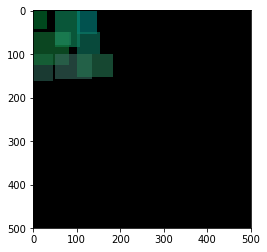

In [80]:
#create blank (black) image
blank = np.zeros( (500, 500, 3), np.uint8 )
blank_img = Image.fromarray(blank, 'RGB')

#create figure and axes
fig,ax = plt.subplots(1)
ax.imshow(blank_img)

for i in range(0, len(rects)):
    posX = rects[i][0]
    posY = rects[i][1]
    width = rects[i][2]
    height = rects[i][3]
    color = rects[i][4]#[0:3]
    tmpRect = patches.Rectangle((posX, posY), width, height, linewidth=0, edgecolor=color, facecolor=color)
    ax.add_patch(tmpRect)
    
plt.imshow(blank_img)

In [81]:
blank2 = np.zeros( (ar_height*size, ar_width*size, 3), np.uint8 )
blank2_img = Image.fromarray(blank2, 'RGB')

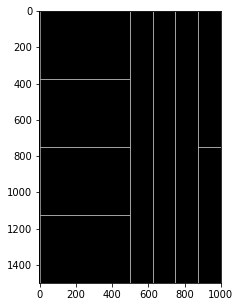

In [82]:
#create figure and axes
fig,ax2 = plt.subplots(figsize=(5,5))
ax2.imshow(blank2_img)

#build image from tree structure
#traverse tree 
def traverseTree(node):
    treeRects = []
    if(node.leftChild == None and node.rightChild == None): #leaf
        #display
        rect = node.image
        position = node.position
        width = rect[2]
        width = node.width
        height = rect[3]
        height = node.height
        #color = rect[4][0:3]
        tmpRect = patches.Rectangle(position, width, height, linewidth=0.5, edgecolor=(1,1,1), facecolor=(0,0,0))
        ax2.add_patch(tmpRect)
        #print(rect)
    else:
        traverseTree(node.leftChild)
        traverseTree(node.rightChild)

traverseTree(root)

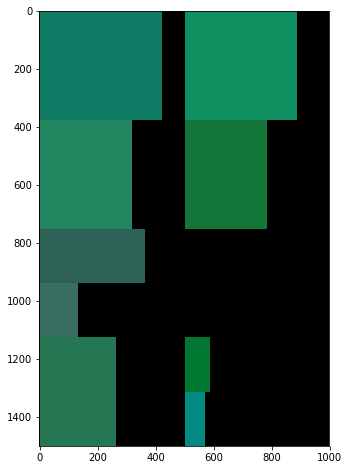

In [46]:
#create figure and axes
fig,ax2 = plt.subplots(figsize=(8,8))
ax2.imshow(blank2_img)

#build image from tree structure
#traverse tree 
def traverseTree(node):
    treeRects = []
    if(node.leftChild == None and node.rightChild == None): #leaf
        #display
        rect = node.image
        position = node.position
        width = rect[2] 
        height = rect[3]
        if(node.height > node.width): # rect_height is bigger than rect_width
            height = (height/width) * node.width
            width = node.width
        else: # rect_width is same or bigger than rect_height
            width = (width/height) * node.height
            height = node.height
        color = rect[4][0:3] #add or remove transparency to see overlapping
        tmpRect = patches.Rectangle(position, width, height, linewidth=0, edgecolor=color, facecolor=color)
        ax2.add_patch(tmpRect)
        #print("width: ", width, ", height: ", height)
    else:
        traverseTree(node.leftChild)
        traverseTree(node.rightChild)

traverseTree(root)